# Etude d'une pi√®ce cubique dans un environnement glacial                         
R√©alis√©e par H√©l√®ne ZHANG

## Objectif : D√©terminer un mod√®le viable du cube en limitant les consommations √©nerg√©tiques

## Sommaire

**I) Pr√©sentation g√©n√©rale : Description du b√¢timent  
II) Hypoth√®ses  
a) Localisation  
b) Dimension du b√¢timent  
c) D√©finition des mat√©riaux utilis√©s  
III) Propri√©t√©s termo-physique  
IV) Circuit Thermique  
a) Conductances thermiques  
b) Capacit√©s thermiques  
c) Source de flux  
V) Syst√®me Equation Diff√©rentielle (DAE)  
VI) Mod√®le en r√©gime stationniaire  
VII) Pour un ordre d'id√©e de la consommation annuelle du mod√®le pr√©c√©dent...  
VIII) Pour la suite...  
IX) Mod√®le dynamique  
X) Optimisation du syst√®me : Equipement id√©al  
a) Valeurs vis√©es pour chacun des environnements  
b) Param√®tre modifiables  
c) Tableau des mat√©riaux  
d) Processus de d√©termination des √©quipements id√©aux  
e) Conclusion  
XI) Am√©lioration possible**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dm4bem
from dm4bem import read_epw, sol_rad_tilt_surf
# import warnings
# warnings.filterwarnings("ignore", category=RuntimeWarning) 

## Pr√©sentation g√©n√©rale : Description du b√¢timent


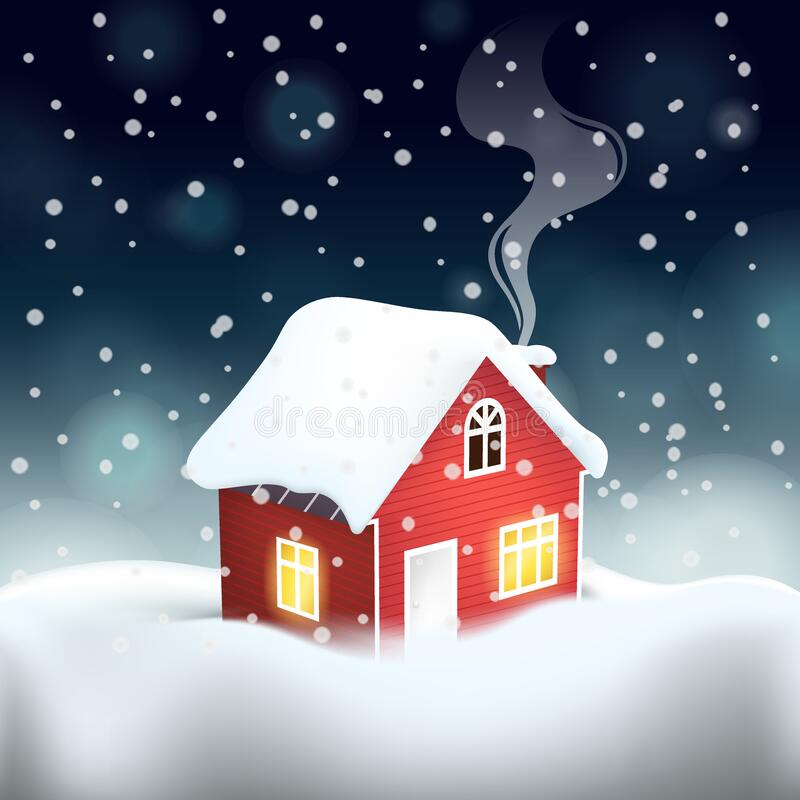
> Figure 1. Image representant la situation g√©n√©rale du projet (de Dreamstime)

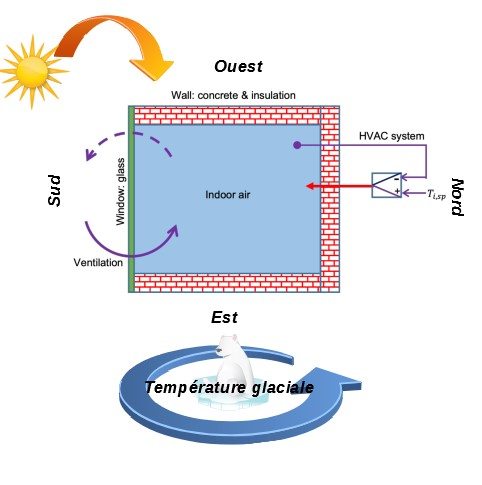
> Figure 2. Schema Repr√©sentatif du mod√®le √©tudi√© (ventilation, 5 murs de 2 couches de mat√©riaux, 1 vitre et un correcteur HVAC)


## Hypoth√®ses

Ainsi, les **hypoth√®ses** retenus sur le syst√®me sont les suivants :
* D√©finition de l'orientation du b√¢timent : Sud c√¥t√© vitr√©
* Localisation : Moscou en Russie
* 5 murs similaires de 2 couches de mat√©riaux (b√©ton et isolation)
* 1 fen√™tre vitr√©e
* 1 m√©canisme de ventilation
* Temp√©rature froide
* Flux solaire sur mur Sud et Est
* Dimension d'un cube (pi√®ce de vie)
* Sol enneig√© sauf la surface de contact entre cube et sol
* Correcteur : syst√®me de r√©gulateur de temp√©rature associ√© au chauffage

### Localisation

L'√©tude du b√¢timent se fait √† Moscou, en Russie.  
\
**Remarque :** Moscou est situ√© dans l'h√©misph√®re nord donc comme la France le soleil se place au sud √† midi.

In [2]:
# filename = './Weather_Data/RUS_MOS_Moscow-Vnukovo.AP.275185_TMYx.2007-2021.epw' # Russie-Moscou
# filename = './Weather_Data/ARG_Buenos.Aires.875760_IWEC.epw' # Argentine-Buenos_Aires
filename = './Weather_Data/ZAF_GT_Johannesburg-Tambo.Intl.AP.683680_TMYx.2007-2021.epw' # Afrique du Sud-Johannesburg

# Lecture du weatherdata
[data, meta] = read_epw(filename, coerce_year=None)

# Selection des param√®tres
weather_data = data[["temp_air", "dir_n_rad", "dif_h_rad"]]
weather_data.index = weather_data.index.map(lambda t: t.replace(year=2008))

# Selectionner date
start_date = '2008-11-30'
end_date = '2008-12-01'

# Ordonner les dates
weather_data = weather_data[(
    weather_data.index >= start_date) & (
    weather_data.index < end_date)]
del data
weather_data

temp_air  dir_n_rad  dif_h_rad
2008-11-30 00:00:00+02:00      19.0          0          0
2008-11-30 01:00:00+02:00      18.0          0          0
2008-11-30 02:00:00+02:00      17.7          0          0
2008-11-30 03:00:00+02:00      17.0          0          0
2008-11-30 04:00:00+02:00      17.0          0          0
2008-11-30 05:00:00+02:00      15.9        422         48
2008-11-30 06:00:00+02:00      16.0        683         82
2008-11-30 07:00:00+02:00      18.0        835         99
2008-11-30 08:00:00+02:00      18.8        908        112
2008-11-30 09:00:00+02:00      21.0        950        120
2008-11-30 10:00:00+02:00      22.0        914        150
2008-11-30 11:00:00+02:00      23.3        865        180
2008-11-30 12:00:00+02:00      25.0        875        174
2008-11-30 13:00:00+02:00      26.0        814        163
2008-11-30 14:00:00+02:00      26.3        766        144
2008-11-30 15:00:00+02:00      27.0        689        124
2008-11-30 16:00:00+02:00      26.0        413        105
2008-11-30 17:00:00+02:00      26.0        117         51
2008-11-30 18:00:00+02:00      23.2          0          7
2008-11-30 19:00:00+02:00      21.8          0          0
2008-11-30 20:00:00+02:00      20.2          0          0
2008-11-30 21:00:00+02:00      19.5          0          0
2008-11-30 22:00:00+02:00      19.5          0          0
2008-11-30 23:00:00+02:00      19.6          0          0

### Dimension du b√¢timent
- $l=3 \: \mathrm{m}$ - Longueur d'un c√¥t√© du cube (On rappelle qu'une chambre a pour dimension minimale 9 m¬≤
- $S_v=l^2$   - Surface de la vitre
- $S_m = S_i = 5 \times S_g$   - Surface des murs identiques

In [3]:
l = 3               # m longueur d
Sv = l**2           # m¬≤ surface of the glass wall
Sm = Si = 5 * Sv    # m¬≤ surface of concrete & insulation of the 5 walls

### D√©finition des mat√©riaux utilis√©s

In [4]:
# Pour la derni√®re partie du projet, le b√©ton est l'√©l√©ment √† changer pour une construction id√©ale (voir partie optimisation). Les valeurs de la colonne sont donc adapt√©s selon le mat√©riau √©tudi√© mais le nom commun reste le b√©ton. Pareillement pour le verre dans le cas d'une vitres sur les 4 faces.



# B√©ton + isolant
wall = {'Conductivite': [1.4, 0.027, 1.4],  # W/(m¬∑K)
        'Densite': [2300, 55, 2500],        # kg/m¬≥
        'Capacite thermique massique': [880, 1210, 750],  # J/(kg¬∑K)
        'Epaisseur': [0.2, 0.08, 0.004],
        'Surface': [5 * l**2, 5 * l**2, l**2],  # m¬≤
        'Nb de couches par mur': [1, 1, 1]} 

"""
# Bois + isolant
wall = {'Conductivite': [0.1825, 0.027, 1.4],  # W/(m¬∑K)
        'Densite': [735, 55, 2500],        # kg/m¬≥
        'Capacite thermique massique': [2300, 1210, 750],  # J/(kg¬∑K)
        'Epaisseur': [0.2, 0.08, 0.004],
        'Surface': [5 * l**2, 5 * l**2, l**2],  # m¬≤
        'Nb de couches par mur': [1, 1, 1]}
"""
"""
# Terre cuite + isolant
wall = {'Conductivite': [0.825, 0.027, 1.4],  # W/(m¬∑K)
        'Densite': [1700, 55, 2500],        # kg/m¬≥
        'Capacite thermique massique': [1000, 1210, 750],  # J/(kg¬∑K)
        'Epaisseur': [0.2, 0.08, 0.004],
        'Surface': [5 * l**2, 5 * l**2, l**2],  # m¬≤
        'Nb de couches par mur': [1, 1, 1]}
"""
"""
# Vitre sur 4 murs
wall = {'Conductivite': [1.4, 1.4, 1.4],  # W/(m¬∑K)
        'Densite': [2300, 2300, 2500],        # kg/m¬≥
        'Capacite thermique massique': [880, 880, 750],  # J/(kg¬∑K)
        'Epaisseur': [0.004, 0.004, 0.004],
        'Surface': [5 * l**2, 5 * l**2, l**2],  # m¬≤
        'Nb de couches par mur': [1, 1, 1]} 
"""

wall = pd.DataFrame(wall, index=['Beton', 'Isolant', 'Verre'])
wall

Conductivite  Densite  Capacite thermique massique  Epaisseur  \
Beton           1.400     2300                          880      0.200   
Isolant         0.027       55                         1210      0.080   
Verre           1.400     2500                          750      0.004   

         Surface  Nb de couches par mur  
Beton         45                      1  
Isolant       45                      1  
Verre          9                      1

Chaque surface a une certaine √©missivit√©, elles sont d√©finies de la mani√®re suivante :  
  
**En grande longueur d'onde**
- Emissivit√© de la surface ext√©rieur du mur (b√©ton)
- Emissivit√© du verre  

**En courte longueur d'onde**
- Absorptivit√© de la surface blanche du mur (√©paisseur nulle)
- Absorptivit√© du verre
- Transmittance du verre

In [5]:
# √† faire un tableau si temps

# Surface du mur (b√©ton)

# Œµ_bg = 0.85       # Emissivit√© : Grande longueur d'onde ---> b√©ton
# Œµ_bg = 0.84       # ---> bois
# Œµ_bg = 0.81       # ---> terre cuite
Œµ_bg = 0.90       # ---> vitre

# Couleur des surfaces
Œ±_coulc = 0.25    # Absorptivit√© : Courte longueur d'onde : mur de couleur blanche

# Verre
Œµ_vg = 0.90       # Emissivit√© : Grande longueur d'onde
Œ±_vc = 0.38       # Absorptivit√© : Courte longueur d'onde
œÑ_vc = 0.30       # Transmittance : Courte longueur d'onde

Le coefficient de Stefan-Boltzmann est :

In [6]:
œÉ = 5.67e-8     # W/(m¬≤‚ãÖK‚Å¥) Stefan-Bolzmann constant
print(f'œÉ = {œÉ} W/(m¬≤‚ãÖK‚Å¥)')

œÉ = 5.67e-08 W/(m¬≤‚ãÖK‚Å¥)


**Facteur de forme entre les surfaces murales et la surface de la vitre**

In [7]:
Fmv = 1 / 5     # view factor wall - glass
print(f'Fmv = {Fmv}')

Fmv = 0.2


**Coefficient d'√©change convectif, h**

In [8]:
h = pd.DataFrame([{'in': 8., 'out': 25}], index=['h'])  # W/(m¬≤‚ãÖK)
h

in  out
h  8.0   25

## Propri√©t√©s thermo-physique

In [9]:
air = {'Densite': 1.2,                      # kg/m¬≥
       'Capacite thermique massique': 1000}               # J/(kg¬∑K)
# pd.DataFrame.from_dict(air, orient='index', columns=['air'])
pd.DataFrame(air, index=['Air'])

Densite  Capacite thermique massique
Air      1.2                         1000

## Circuit Thermique

**Transferts de chaleur :**
- √† travers le mur (b√©ton et isolation), 
- √† travers l'√©paisseur de la vitre,
- par ventilation (VMC),
- √† partir d'une source interne,
- du syst√®me HVAC.

HVAC (chauffage)

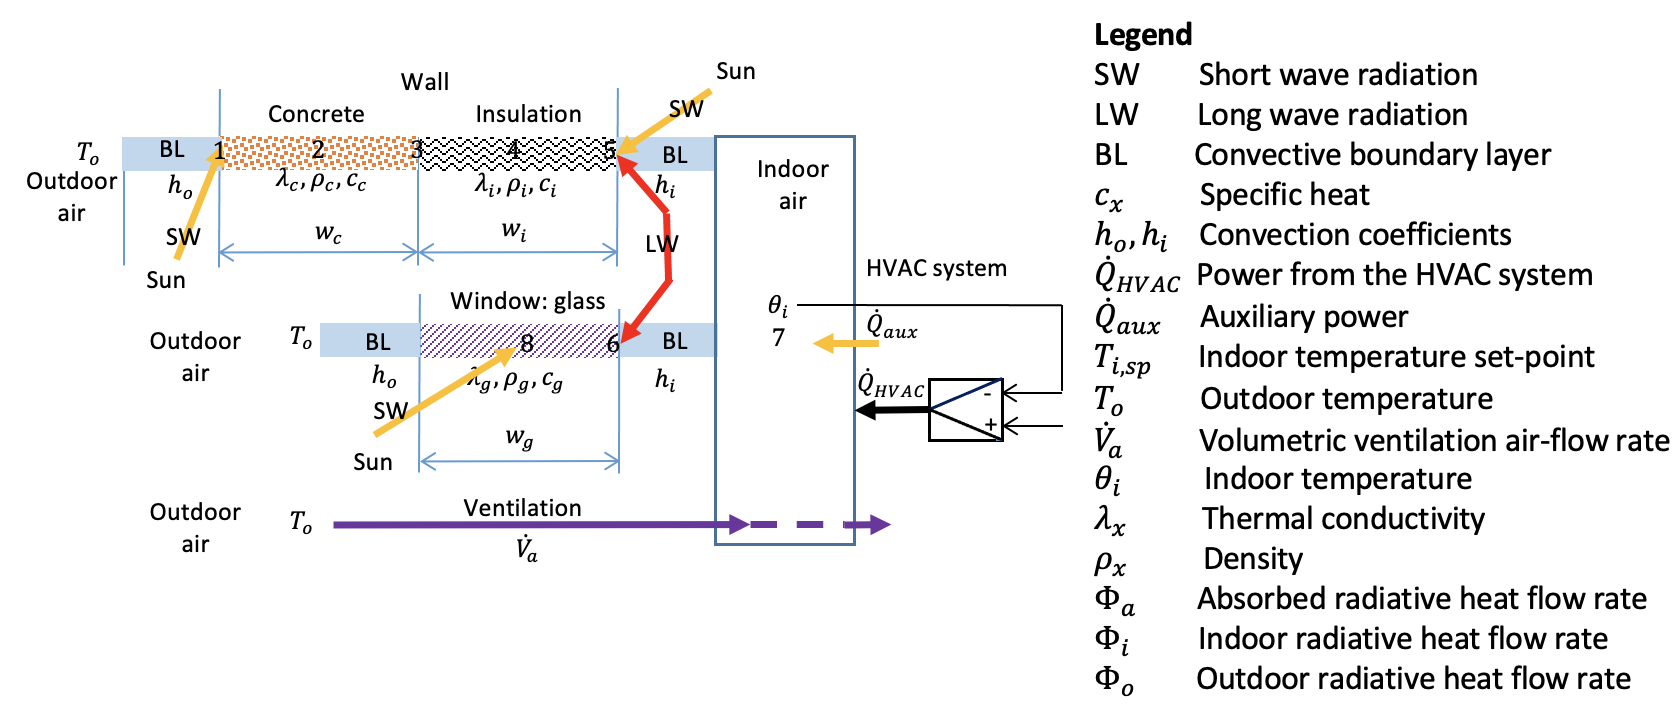
> Figure 3. Les diff√©rents transferts de chaleur appliqu√©s sur le cube

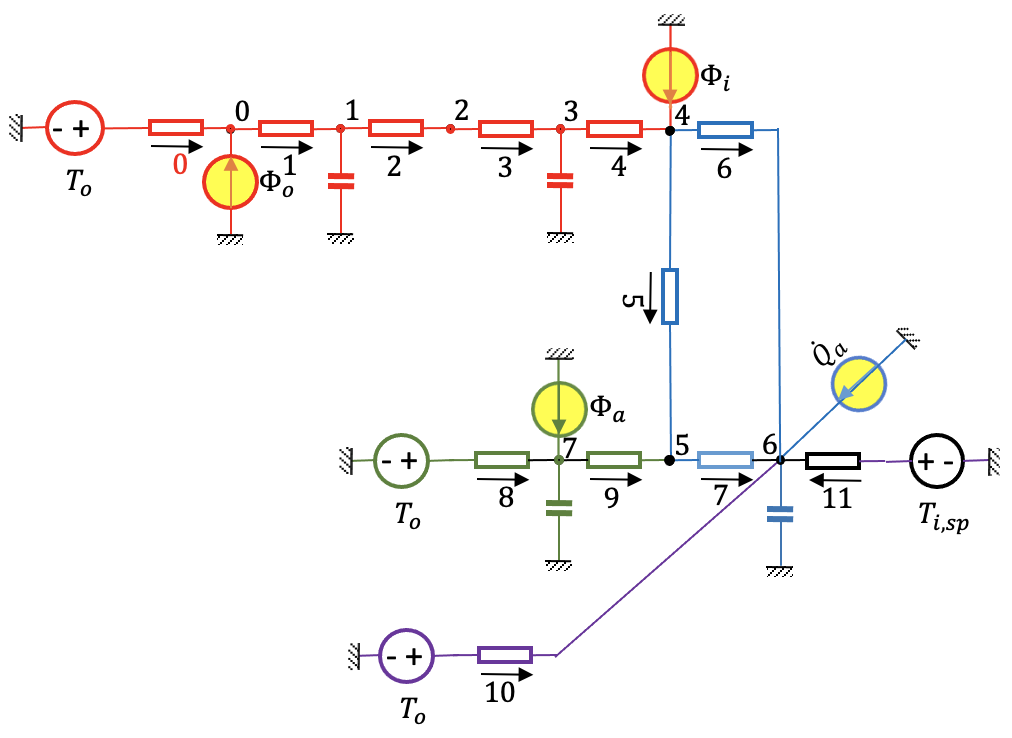
> Figure 4. Sch√©ma du circuit thermique du syst√®me √©tudi√©

La figure 4 montre le mod√®le suivant :
- Mur en b√©ton et isolant : en rouge;
- Fen√™tre en verre : en vert;
- Ventilation : en violet;
- Volume int√©rieur : en bleu (conductances 6 & 7 pour la convection; conductance 5 pour les √©changes radiatifs entre les murs et la fen√™tre);
- Syst√®me HVAC : en noir.
    
    
Les sources sont :
- $T_ext$ - Temp√©rature ext√©rieur, ¬∞C;
- $T_{i,sp}$ - Temp√©rature vis√©e par le correcteur, ¬∞C;
- $\Phi_{s,n,ext}$ - Flux solaire **et Flux solaire d√©vi√© par la neige** re√ßus √† la surface des murs ext√©rieurs, W;
- $\Phi_{s,n,int}$ - Flux solaire **et Flux solaire d√©vi√© par la neige** re√ßus √† la surface des murs int√©rieurs, W;
- $\dot{Q}_{int}$ - Flux interne du b√¢timent (ex : g√©n√©r√©s par les occupants, les fils √©lectriques, etc.), W;
- $\Phi_a$ - Flux solaire re√ßu sur la vitre, W.

### Conductances Thermiques

**Conduction**

Les conductances conductives (W/K) 1, 2, 3, et 4 du circuit thermique de la figure 4 sont travers√©es par des flux g√©n√©r√©s par conduction. Elles sont de la forme :
$$G_{cd} = \frac{\lambda}{w}S$$

Avec :

- $\lambda$ - Conductivit√© Thermique, W/(m‚ãÖK);
- $w$ - Epaisseur du mat√©riau, m;
- $S$ - Surface du mur, m¬≤.

In [10]:
# Conduction
G_cd = wall['Conductivite'] / wall['Epaisseur'] * wall['Surface']
pd.DataFrame(G_cd, columns={'Conductance'})

Conductance
Beton       315.0000
Isolant      15.1875
Verre      3150.0000

**Convection**

Les conductances convectives (W/K) 0, 6 and 7 sont travers√©es par des flux g√©n√©r√©s par convection. Elles sont de la forme :
$$G_{cv} = {h S}$$

Avec :
- $h$ - Coefficient Convectif, W/(m¬≤‚ãÖK);
- $S$ - Surface du mur, m¬≤. 

In [11]:
# Convection
G_cvm = h * wall['Surface'][0]     # Mur en b√©ton
G_cvv = h * wall['Surface'][2]     # Verre

**Echanges radiatifs**

Il y en a plusieurs dans le syst√®me :

* Entre noeuds 4 et 5, √©change entre mur et vitre
* Echange entre sol enneig√© et mur ext√©rieur ---> Sauf qu'on le n√©glige car $S_{ext}$ << $S_{solneige}$, le facteur de forme devient nul du sol au mur, ce qui supprime la liaison entre les 2 surfaces (conductance radiative nulle).

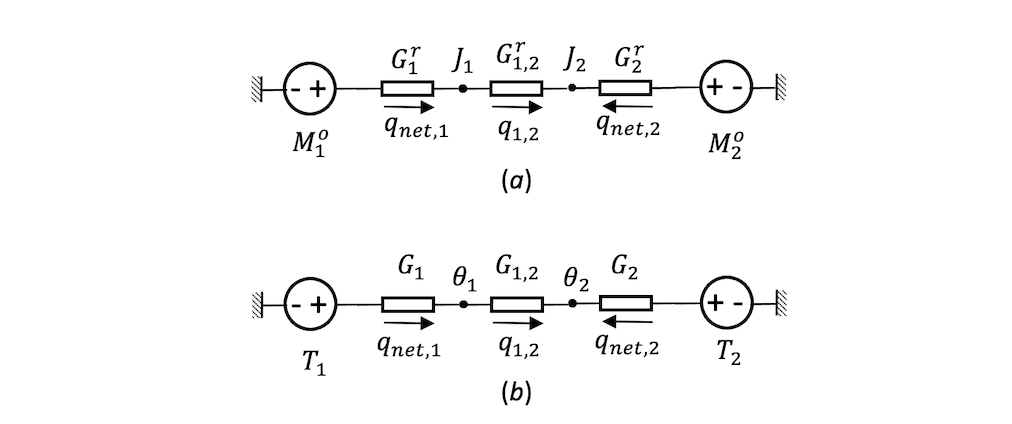
> Figure 5. Echange radiatif entre 2 surfaces : a) mod√®le emmittance (source) et radiosit√© (noeuds), b) mod√®le lin√©aire de l'√©mittance (source de temp√©rature) et de radiosit√© (noeuds de temp√©rature)


Les diff√©rentes conductances radiatives sont calcul√©es avec les expressions suivantes :
$$G_{1}^{r} = \frac{\varepsilon_1}{1 - \varepsilon_1} S_1$$

$$G_{1,2}^{r} = F_{1,2} S_1 = F_{2,1} S_2$$

$$G_{2}^{r} = \frac{\varepsilon_2}{1 - \varepsilon_2} S_2$$

In [12]:
Tm = 15 + 273   # K, mean temp for radiative exchange

# Echange radiatif entre verre et isolant
GR1 = 4 * œÉ * Tm**3 * Œµ_bg / (1 - Œµ_bg) * wall['Surface']['Isolant'] # 1 : Isolant
GR12 = 4 * œÉ * Tm**3 * Fmv * wall['Surface']['Isolant']
GR2 = 4 * œÉ * Tm**3 * Œµ_vg / (1 - Œµ_vg) * wall['Surface']['Verre'] # 2 : Verre

La conductance √©quivalente de l'√©change entre isolant et verre est : 
$$GR = \frac{1}{1/G_1 + 1/G_{1,2} + 1/G_2}$$

In [13]:
GR = 1 / (1 / GR1 + 1 / GR12 + 1 / GR2)

**Advection**

Le d√©bit volumique de l'air, en m¬≥/s, est :
$$\dot{V}_a = \frac{\mathrm{ACH}}{3600} V_a$$

In [14]:
Va = l**3                   # m¬≥ volume de l'air
ACH = 1000                    # 1/h quantit√© d'air entrant par heure
Va_dot = ACH / 3600 * Va    # m¬≥/s D√©bit volumique d'air

Ainsi on peut calculer la conductance advectif, c'est-√†-dire celle qui est travers√©e par un flux g√©n√©r√© par advection :
$$G_v = \rho_a c_a \dot{V}_a$$

In [15]:
# ventilation & advection
Gv = air['Densite'] * air['Capacite thermique massique'] * Va_dot

**Correcteur**

In [16]:
# P-controler gain
# Kp = 1e4            # correction presque maximale Kp -> ‚àû
Kp = 1e-3           # pas de correction Kp -> 0
# Kp = 0
# Kp = 1              # Correction minime

**Equivalence des conductances**

Les conductances conductifs et convectifs entre vitre-air sont parall√®les, leur r√©sistance √©quivalente vaut alors :
$$ G_{equivv} = \frac{1}{1/G_{cvv } + 1/(2 G_{cd})} =  
\frac{1}{\frac{1}{h_{out} S_v} + \frac{w / 2}{\lambda S_v}}
$$

In [17]:
# verre : convection et conduction
G_equivv = float(1 / (1 / G_cvv['out'] + 1 / (2 * G_cd['Verre'])))

### Capacit√©s thermiques

**Mur**  
\
Les capacit√©s thermiques du mur, en J/kg, sont de la forme :

$$C_w= m_w c_w= \rho_w c_w w_w S_w$$

Avec :

- $m_w = \rho_w w_w S_w$ - Masse du mur, kg;
- $c_w$ - Capacit√© thermique massique du mat√©riau, J/(kg‚ãÖK);
- $\rho_w$ - Densit√©, kg/m¬≥;
- $w_w$ - Epaisseur du mur, m;
- $S_w$ - Surface du mur, m¬≤.

In [18]:
Cw = wall['Densite'] * wall['Capacite thermique massique'] * wall['Surface'] * wall['Epaisseur']

**Air**  
\
De fa√ßon analogique, on en d√©duit que :
$$C_a = m_a c_a = \rho_a c_a V_a$$

Avec :

- $m_a = \rho_a V_a$ - Masse du, kg;
- $\rho_w$ - Densit√© de l'air, kg/m¬≥;
- $c_a$ - Capacit√© thermique massique du mat√©riau, J/(kg‚ãÖK);
- $V_a$ - Volume d'air, m¬≥.

In [19]:
Cw['Air'] = air['Densite'] * air['Capacite thermique massique'] * Va
pd.DataFrame(Cw, columns={'Capacite'})

Capacite
Beton    18216000.0
Isolant    239580.0
Verre       67500.0
Air         32400.0

### Source de flux

**Correction Temperature par HVAC**  
Le flux d√©livr√© par le HVAC d√©pend uniquement de la temp√©rature ext√©rieure($\theta_i$) et de la valeur vis√©e($T_{i, sp}$) avec bien s√ªr son coefficient correctif($K_p$) :
$$ q_{HVAC} = K_p (T_{i, sp} - \theta_i)$$

**Flux solaire**   
de l'algorithme : sol_rad_tilt_surf

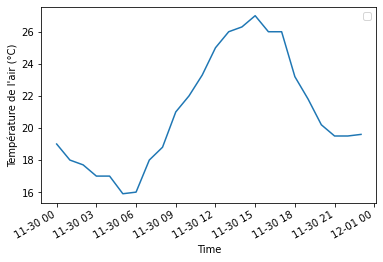

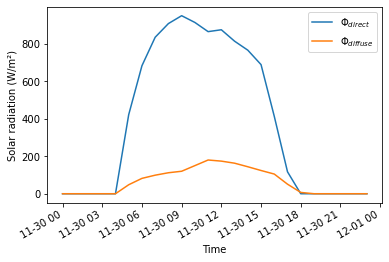

In [20]:
# Evolution temporelle de la temp√©rature 
weather_data[['temp_air']].plot()
plt.xlabel("Time")
plt.ylabel("Temp√©rature de l'air (¬∞C)")
plt.legend([])
plt.show()

# Evolution du flux solaire par rapport √† l'intervalle de temps √©tudi√©
weather_data[['dir_n_rad', 'dif_h_rad']].plot()
plt.xlabel("Time")
plt.ylabel("Solar radiation (W/m¬≤)")
plt.legend(['$Œ¶_{direct}$', '$Œ¶_{diffuse}$'])
plt.show()

Sur cet intervalle de temps, il y a peu de jours o√π le soleil est pr√©sent.

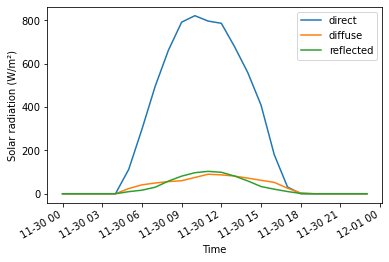

In [21]:
# Definition orientation
surface_orientation_S = {'slope': 90, 
                       'azimuth': 0, 
                       'latitude': 45} # A red√©finir--> recherche google
pd.Series(surface_orientation_S)

albedo = 0.2    # Consi√®re qu'il neige souvent donc neige fra√Æche, 0.2 pour les autres localisations

rad_surf = sol_rad_tilt_surf(
    weather_data, surface_orientation_S, albedo)

rad_surf.plot()
plt.xlabel("Time")
plt.ylabel("Solar radiation (W/m¬≤)")
plt.show()

> Figure 6. Evolution du flux solaire direct, diffus√© et r√©fl√©chi par rapport au temps

On constate qu'une grande partie du flux solaire que re√ßoit un des murs vient de sa r√©flection avec l'environnement soit la neige. Les rayons provenant de la r√©flection sur le sol ne sont pas n√©gligeables. Il faut donc puiser le plus possible de cette source par la suite.

La somme de ces 3 flux : direct, diffuse et reflection donne le flux total re√ßu par la surface murale :
$$ G_{sr} = G_{dir} + G_{dif} + G_r$$

**Mur Sud**

In [22]:
Œ≤ = surface_orientation_S['slope']
Œ≥ = surface_orientation_S['azimuth']
œï = surface_orientation_S['latitude']

# Conversion en rad
Œ≤ = Œ≤ * np.pi / 180
Œ≥ = Œ≥ * np.pi / 180
œï = œï * np.pi / 180

n = weather_data.index.dayofyear

* Direct Radiation

In [23]:
# Angle entre le soleil √† 9h et l'√©quateur
declination_angle = 23.45 * np.sin(360 * (284 + n) / 365 * np.pi / 180)
Œ¥ = declination_angle * np.pi / 180

# Recherche de œâ 
hour = weather_data.index.hour
minute = weather_data.index.minute + 60
hour_angle = 15 * ((hour + minute / 60) - 12)   # deg
œâ = hour_angle * np.pi / 180                    # rad

# D√©termination de l'angle entre la normale √† la surface (mur) et du soleil
theta = np.sin(Œ¥) * np.sin(œï) * np.cos(Œ≤)
theta -= np.sin(Œ¥) * np.cos(œï) * np.sin(Œ≤) * np.cos(Œ≥)
theta += np.cos(Œ¥) * np.cos(œï) * np.cos(Œ≤) * np.cos(œâ)
theta += np.cos(Œ¥) * np.sin(œï) * np.sin(Œ≤) * np.cos(Œ≥) * np.cos(œâ)
theta += np.cos(Œ¥) * np.sin(Œ≤) * np.sin(Œ≥) * np.sin(œâ)
theta = np.array(np.arccos(theta))
theta[theta > (np.pi / 2)] = np.pi / 2

# Flux solaire Direct
dir_rad_S = weather_data["dir_n_rad"] * np.cos(theta)
dir_rad_S[dir_rad_S < 0] = 0

- Radiation Diffus√©e

In [24]:
dif_rad_S = weather_data["dif_h_rad"] * (1 + np.cos(Œ≤)) / 2

- Radiation apr√®s r√©flection au sol

In [25]:
# Calcul de la radiation horizontale diffus√©e
gamma = np.cos(Œ¥) * np.cos(œï) * np.cos(œâ)
gamma += np.sin(Œ¥) * np.sin(œï)
gamma = np.array(np.arcsin(gamma))
gamma[gamma < 1e-5] = 1e-5

dir_h_rad = weather_data["dir_n_rad"] * np.sin(gamma)

# Flux solaire apr√®s r√©flection sur le sol
ref_rad_S = (dir_h_rad + weather_data["dif_h_rad"]) * albedo * (1 + np.cos(Œ≤) / 2)

- Radiation Totale

In [26]:
Gtot_S = dir_rad_S + dif_rad_S + ref_rad_S
Gtot_S

2008-11-30 00:00:00+02:00      0.000000
2008-11-30 01:00:00+02:00      0.000000
2008-11-30 02:00:00+02:00      0.000000
2008-11-30 03:00:00+02:00      0.000000
2008-11-30 04:00:00+02:00      0.000000
2008-11-30 05:00:00+02:00    145.903201
2008-11-30 06:00:00+02:00    354.968432
2008-11-30 07:00:00+02:00    575.282178
2008-11-30 08:00:00+02:00    776.454155
2008-11-30 09:00:00+02:00    933.029042
2008-11-30 10:00:00+02:00    993.637178
2008-11-30 11:00:00+02:00    990.167780
2008-11-30 12:00:00+02:00    972.519399
2008-11-30 13:00:00+02:00    841.583832
2008-11-30 14:00:00+02:00    689.687095
2008-11-30 15:00:00+02:00    504.311042
2008-11-30 16:00:00+02:00    253.435231
2008-11-30 17:00:00+02:00     66.836196
2008-11-30 18:00:00+02:00      4.900000
2008-11-30 19:00:00+02:00      0.000000
2008-11-30 20:00:00+02:00      0.000000
2008-11-30 21:00:00+02:00      0.000000
2008-11-30 22:00:00+02:00      0.000000
2008-11-30 23:00:00+02:00      0.000000
dtype: float64

**Ensemble Mur Nord, Est et Ouest**

On proc√®de de la m√™me fa√ßon pour d√©terminer le flux total solaire que re√ßoit les murs Nord, Est et Ouest.

- Nord

In [27]:
surface_orientation_N = {'slope': 90, 
                       'azimuth': 180, 
                       'latitude': 45} # A red√©finir--> recherche google
pd.Series(surface_orientation_N)

albedo = 0.70 # Consi√®re qu'il neige souvent

rad_surf = sol_rad_tilt_surf(
    weather_data, surface_orientation_N, albedo)

Œ≤ = surface_orientation_N['slope']
Œ≥ = surface_orientation_N['azimuth']
œï = surface_orientation_N['latitude']

# Conversion en rad
Œ≤ = Œ≤ * np.pi / 180
Œ≥ = Œ≥ * np.pi / 180
œï = œï * np.pi / 180

n = weather_data.index.dayofyear

# Angle entre le soleil √† 9h et l'√©quateur
declination_angle = 23.45 * np.sin(360 * (284 + n) / 365 * np.pi / 180)
Œ¥ = declination_angle * np.pi / 180

# Recherche de œâ 
hour = weather_data.index.hour
minute = weather_data.index.minute + 60
hour_angle = 15 * ((hour + minute / 60) - 12)   # deg
œâ = hour_angle * np.pi / 180                    # rad

# D√©termination de l'angle entre la normale √† la surface (mur) et du soleil
theta = np.sin(Œ¥) * np.sin(œï) * np.cos(Œ≤)
theta -= np.sin(Œ¥) * np.cos(œï) * np.sin(Œ≤) * np.cos(Œ≥)
theta += np.cos(Œ¥) * np.cos(œï) * np.cos(Œ≤) * np.cos(œâ)
theta += np.cos(Œ¥) * np.sin(œï) * np.sin(Œ≤) * np.cos(Œ≥) * np.cos(œâ)
theta += np.cos(Œ¥) * np.sin(Œ≤) * np.sin(Œ≥) * np.sin(œâ)
theta = np.array(np.arccos(theta))
theta[theta > (np.pi / 2)] = np.pi / 2

# Flux solaire Direct
dir_rad_N = weather_data["dir_n_rad"] * np.cos(theta)
dir_rad_N[dir_rad_N < 0] = 0
dir_rad_N 

# Flux solaire diffus√©
dif_rad_N = weather_data["dif_h_rad"] * (1 + np.cos(Œ≤)) / 2

# Calcul de la radiation horizontale diffus√©e
gamma = np.cos(Œ¥) * np.cos(œï) * np.cos(œâ)
gamma += np.sin(Œ¥) * np.sin(œï)
gamma = np.array(np.arcsin(gamma))
gamma[gamma < 1e-5] = 1e-5

dir_h_rad = weather_data["dir_n_rad"] * np.sin(gamma)

# Flux solaire apr√®s r√©flection sur le sol
ref_rad_N = (dir_h_rad + weather_data["dif_h_rad"]) * albedo * (1 + np.cos(Œ≤) / 2)

# Flux total
Gtot_N = dir_rad_N + dif_rad_N + ref_rad_N
Gtot_N

2008-11-30 00:00:00+02:00      0.000000
2008-11-30 01:00:00+02:00      0.000000
2008-11-30 02:00:00+02:00      0.000000
2008-11-30 03:00:00+02:00      0.000000
2008-11-30 04:00:00+02:00      0.000000
2008-11-30 05:00:00+02:00     57.602954
2008-11-30 06:00:00+02:00     98.404781
2008-11-30 07:00:00+02:00    154.711690
2008-11-30 08:00:00+02:00    259.689180
2008-11-30 09:00:00+02:00    344.318017
2008-11-30 10:00:00+02:00    414.599775
2008-11-30 11:00:00+02:00    451.539115
2008-11-30 12:00:00+02:00    433.389500
2008-11-30 13:00:00+02:00    367.240912
2008-11-30 14:00:00+02:00    278.495498
2008-11-30 15:00:00+02:00    178.432520
2008-11-30 16:00:00+02:00    126.002891
2008-11-30 17:00:00+02:00     61.200819
2008-11-30 18:00:00+02:00      8.400000
2008-11-30 19:00:00+02:00      0.000000
2008-11-30 20:00:00+02:00      0.000000
2008-11-30 21:00:00+02:00      0.000000
2008-11-30 22:00:00+02:00      0.000000
2008-11-30 23:00:00+02:00      0.000000
dtype: float64

- Ouest

In [28]:
surface_orientation_O = {'slope': 90, 
                       'azimuth': 90, 
                       'latitude': 45} # A red√©finir--> recherche google
pd.Series(surface_orientation_O)

albedo = 0.70 # Consi√®re qu'il neige souvent

rad_surf = sol_rad_tilt_surf(
    weather_data, surface_orientation_O, albedo)

Œ≤ = surface_orientation_O['slope']
Œ≥ = surface_orientation_O['azimuth']
œï = surface_orientation_O['latitude']

# Conversion en rad
Œ≤ = Œ≤ * np.pi / 180
Œ≥ = Œ≥ * np.pi / 180
œï = œï * np.pi / 180

n = weather_data.index.dayofyear

# Angle entre le soleil √† 9h et l'√©quateur
declination_angle = 23.45 * np.sin(360 * (284 + n) / 365 * np.pi / 180)
Œ¥ = declination_angle * np.pi / 180

# Recherche de œâ 
hour = weather_data.index.hour
minute = weather_data.index.minute + 60
hour_angle = 15 * ((hour + minute / 60) - 12)   # deg
œâ = hour_angle * np.pi / 180                    # rad

# D√©termination de l'angle entre la normale √† la surface (mur) et du soleil
theta = np.sin(Œ¥) * np.sin(œï) * np.cos(Œ≤)
theta -= np.sin(Œ¥) * np.cos(œï) * np.sin(Œ≤) * np.cos(Œ≥)
theta += np.cos(Œ¥) * np.cos(œï) * np.cos(Œ≤) * np.cos(œâ)
theta += np.cos(Œ¥) * np.sin(œï) * np.sin(Œ≤) * np.cos(Œ≥) * np.cos(œâ)
theta += np.cos(Œ¥) * np.sin(Œ≤) * np.sin(Œ≥) * np.sin(œâ)
theta = np.array(np.arccos(theta))
theta[theta > (np.pi / 2)] = np.pi / 2

# Flux solaire Direct
dir_rad_O = weather_data["dir_n_rad"] * np.cos(theta)
dir_rad_O[dir_rad_O < 0] = 0
dir_rad_O 

# Flux solaire diffus√©
dif_rad_O = weather_data["dif_h_rad"] * (1 + np.cos(Œ≤)) / 2

# Calcul de la radiation horizontale diffus√©e
gamma = np.cos(Œ¥) * np.cos(œï) * np.cos(œâ)
gamma += np.sin(Œ¥) * np.sin(œï)
gamma = np.array(np.arcsin(gamma))
gamma[gamma < 1e-5] = 1e-5

dir_h_rad = weather_data["dir_n_rad"] * np.sin(gamma)

# Flux solaire apr√®s r√©flection sur le sol
ref_rad_O = (dir_h_rad + weather_data["dif_h_rad"]) * albedo * (1 + np.cos(Œ≤) / 2)

# Flux total
Gtot_O = dir_rad_O + dif_rad_O + ref_rad_O
Gtot_O

2008-11-30 00:00:00+02:00      0.000000
2008-11-30 01:00:00+02:00      0.000000
2008-11-30 02:00:00+02:00      0.000000
2008-11-30 03:00:00+02:00      0.000000
2008-11-30 04:00:00+02:00      0.000000
2008-11-30 05:00:00+02:00     57.602954
2008-11-30 06:00:00+02:00     98.404781
2008-11-30 07:00:00+02:00    154.711690
2008-11-30 08:00:00+02:00    259.689180
2008-11-30 09:00:00+02:00    344.318017
2008-11-30 10:00:00+02:00    414.599775
2008-11-30 11:00:00+02:00    451.539115
2008-11-30 12:00:00+02:00    643.205824
2008-11-30 13:00:00+02:00    744.317352
2008-11-30 14:00:00+02:00    780.316417
2008-11-30 15:00:00+02:00    731.253916
2008-11-30 16:00:00+02:00    495.600216
2008-11-30 17:00:00+02:00    169.598715
2008-11-30 18:00:00+02:00      8.400000
2008-11-30 19:00:00+02:00      0.000000
2008-11-30 20:00:00+02:00      0.000000
2008-11-30 21:00:00+02:00      0.000000
2008-11-30 22:00:00+02:00      0.000000
2008-11-30 23:00:00+02:00      0.000000
dtype: float64

- Est

In [29]:
surface_orientation_E = {'slope': 90, 
                       'azimuth': 270, 
                       'latitude': 45} # A red√©finir--> recherche google
pd.Series(surface_orientation_E)

albedo = 0.70 # Consi√®re qu'il neige souvent

rad_surf = sol_rad_tilt_surf(
    weather_data, surface_orientation_E, albedo)

Œ≤ = surface_orientation_E['slope']
Œ≥ = surface_orientation_E['azimuth']
œï = surface_orientation_E['latitude']

# Conversion en rad
Œ≤ = Œ≤ * np.pi / 180
Œ≥ = Œ≥ * np.pi / 180
œï = œï * np.pi / 180

n = weather_data.index.dayofyear

# Angle entre le soleil √† 9h et l'√©quateur
declination_angle = 23.45 * np.sin(360 * (284 + n) / 365 * np.pi / 180)
Œ¥ = declination_angle * np.pi / 180

# Recherche de œâ 
hour = weather_data.index.hour
minute = weather_data.index.minute + 60
hour_angle = 15 * ((hour + minute / 60) - 12)   # deg
œâ = hour_angle * np.pi / 180                    # rad

# D√©termination de l'angle entre la normale √† la surface (mur) et du soleil
theta = np.sin(Œ¥) * np.sin(œï) * np.cos(Œ≤)
theta -= np.sin(Œ¥) * np.cos(œï) * np.sin(Œ≤) * np.cos(Œ≥)
theta += np.cos(Œ¥) * np.cos(œï) * np.cos(Œ≤) * np.cos(œâ)
theta += np.cos(Œ¥) * np.sin(œï) * np.sin(Œ≤) * np.cos(Œ≥) * np.cos(œâ)
theta += np.cos(Œ¥) * np.sin(Œ≤) * np.sin(Œ≥) * np.sin(œâ)
theta = np.array(np.arccos(theta))
theta[theta > (np.pi / 2)] = np.pi / 2

# Flux solaire Direct
dir_rad_E = weather_data["dir_n_rad"] * np.cos(theta)
dir_rad_E[dir_rad_E < 0] = 0
dir_rad_E 

# Flux solaire diffus√©
dif_rad_E = weather_data["dif_h_rad"] * (1 + np.cos(Œ≤)) / 2

# Calcul de la radiation horizontale diffus√©e
gamma = np.cos(Œ¥) * np.cos(œï) * np.cos(œâ)
gamma += np.sin(Œ¥) * np.sin(œï)
gamma = np.array(np.arcsin(gamma))
gamma[gamma < 1e-5] = 1e-5

dir_h_rad = weather_data["dir_n_rad"] * np.sin(gamma)

# Flux solaire apr√®s r√©flection sur le sol
ref_rad_E = (dir_h_rad + weather_data["dif_h_rad"]) * albedo * (1 + np.cos(Œ≤) / 2)

# Flux total
Gtot_E = dir_rad_E + dif_rad_E + ref_rad_E
Gtot_E

2008-11-30 00:00:00+02:00      0.000000
2008-11-30 01:00:00+02:00      0.000000
2008-11-30 02:00:00+02:00      0.000000
2008-11-30 03:00:00+02:00      0.000000
2008-11-30 04:00:00+02:00      0.000000
2008-11-30 05:00:00+02:00    448.576561
2008-11-30 06:00:00+02:00    709.627476
2008-11-30 07:00:00+02:00    824.676662
2008-11-30 08:00:00+02:00    854.536953
2008-11-30 09:00:00+02:00    784.394944
2008-11-30 10:00:00+02:00    633.767912
2008-11-30 11:00:00+02:00    451.539115
2008-11-30 12:00:00+02:00    433.389500
2008-11-30 13:00:00+02:00    367.240912
2008-11-30 14:00:00+02:00    278.495498
2008-11-30 15:00:00+02:00    178.432520
2008-11-30 16:00:00+02:00    126.002891
2008-11-30 17:00:00+02:00     61.200819
2008-11-30 18:00:00+02:00      8.400000
2008-11-30 19:00:00+02:00      0.000000
2008-11-30 20:00:00+02:00      0.000000
2008-11-30 21:00:00+02:00      0.000000
2008-11-30 22:00:00+02:00      0.000000
2008-11-30 23:00:00+02:00      0.000000
dtype: float64

In [30]:
# FLux total direct
Gtot_dir = dir_rad_N + dir_rad_E + dir_rad_O

# Flux total
Gtot_NEO = Gtot_N + Gtot_E + Gtot_O

**Flux radiatif mur interne**

Le flux radiatif des murs internes est calcul√© √† partir des op√©rations matricielles, il en r√©sulte :
$$ \Phi = S E $$

In [31]:
I = np.identity(2)
  
œÅ = np.zeros([2, 2])
œÅ[0, 0], œÅ[1, 1] = 1-Œµ_bg, 1-Œ±_vc-œÑ_vc

F = np.zeros([2, 2])
F[0, 0], F[1, 1] = 1-Fmv, 0
F[0, 1], F[1, 0] = Fmv, 1

sum_dir = 0
sum_S = 0
for i in range (len(Gtot_dir)) : 
    sum_dir += Gtot_dir[i]
    sum_S += dir_rad_S[i]

moy_dir = sum_dir/len(Gtot_dir)
moy_S = sum_S/len(dir_rad_S)

E0 = [[moy_dir], [moy_S]]

E = ((I-œÅ.dot(F))**(-1)).dot(E0)

# Calcul du flux radiatif interne
S = np.zeros([2, 2])
S[0, 0], S[1, 1] = Sm, Sv

Œ¶Rint = S.dot(E)
Œ¶Rint

array([[-610521.57940806],
       [  -3429.80817701]])

**Flux interne**

In [32]:
Œ¶int = 100*1 # 1 personne dans le b√¢ti

## Syst√®me Equation Diff√©rentielle (DAE) 

**Matrice de Connexion**

In [33]:
A = np.zeros([12, 8])       # n¬∞ of branches X n¬∞ of nodes
A[0, 0] = 1                 # branche 0: -> node 0
A[1, 0], A[1, 1] = -1, 1    # branche 1: node 0 -> node 1
A[2, 1], A[2, 2] = -1, 1    # branche 2: node 1 -> node 2
A[3, 2], A[3, 3] = -1, 1    # branche 3: node 2 -> node 3
A[4, 3], A[4, 4] = -1, 1    # branche 4: node 3 -> node 4
A[5, 4], A[5, 5] = -1, 1    # branche 5: node 4 -> node 5
A[6, 4], A[6, 6] = -1, 1    # branche 6: node 4 -> node 6
A[7, 5], A[7, 6] = -1, 1    # branche 7: node 5 -> node 6
A[8, 7] = 1                 # branche 8: -> node 7
A[9, 5], A[9, 7] = 1, -1    # branche 9: node 5 -> node 7
A[10, 6] = 1                # branche 10: -> node 6
A[11, 6] = 1                # branche 11: -> node 6
np.set_printoptions(suppress=False)
pd.DataFrame(A)

0    1    2    3    4    5    6    7
0   1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1  -1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
2   0.0 -1.0  1.0  0.0  0.0  0.0  0.0  0.0
3   0.0  0.0 -1.0  1.0  0.0  0.0  0.0  0.0
4   0.0  0.0  0.0 -1.0  1.0  0.0  0.0  0.0
5   0.0  0.0  0.0  0.0 -1.0  1.0  0.0  0.0
6   0.0  0.0  0.0  0.0 -1.0  0.0  1.0  0.0
7   0.0  0.0  0.0  0.0  0.0 -1.0  1.0  0.0
8   0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0
9   0.0  0.0  0.0  0.0  0.0  1.0  0.0 -1.0
10  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0
11  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0

**Conductance**

In [34]:
G = np.diag([G_cvm.iloc[0]['out'], 2 * G_cd['Beton'], 2 * G_cd['Beton'],
             2 * G_cd['Isolant'], 2 * G_cd['Isolant'],
             GR, G_cvm.iloc[0]['in'], G_cvm.iloc[0]['in'], G_equivv,
             2 * G_cd['Verre'], Gv, Kp])
np.set_printoptions(precision=3, threshold=16, suppress=True)
pd.set_option("display.precision", 1)
pd.DataFrame(G)

0      1      2     3     4     5      6      7      8       9  \
0   1125.0    0.0    0.0   0.0   0.0   0.0    0.0    0.0    0.0     0.0   
1      0.0  630.0    0.0   0.0   0.0   0.0    0.0    0.0    0.0     0.0   
2      0.0    0.0  630.0   0.0   0.0   0.0    0.0    0.0    0.0     0.0   
3      0.0    0.0    0.0  30.4   0.0   0.0    0.0    0.0    0.0     0.0   
4      0.0    0.0    0.0   0.0  30.4   0.0    0.0    0.0    0.0     0.0   
5      0.0    0.0    0.0   0.0   0.0  43.0    0.0    0.0    0.0     0.0   
6      0.0    0.0    0.0   0.0   0.0   0.0  360.0    0.0    0.0     0.0   
7      0.0    0.0    0.0   0.0   0.0   0.0    0.0  360.0    0.0     0.0   
8      0.0    0.0    0.0   0.0   0.0   0.0    0.0    0.0  217.2     0.0   
9      0.0    0.0    0.0   0.0   0.0   0.0    0.0    0.0    0.0  6300.0   
10     0.0    0.0    0.0   0.0   0.0   0.0    0.0    0.0    0.0     0.0   
11     0.0    0.0    0.0   0.0   0.0   0.0    0.0    0.0    0.0     0.0   

        10       11  
0      0.0  0.0e+00  
1      0.0  0.0e+00  
2      0.0  0.0e+00  
3      0.0  0.0e+00  
4      0.0  0.0e+00  
5      0.0  0.0e+00  
6      0.0  0.0e+00  
7      0.0  0.0e+00  
8      0.0  0.0e+00  
9      0.0  0.0e+00  
10  9000.0  0.0e+00  
11     0.0  1.0e-03

**Capacit√©**

In [35]:
Cwtot = np.diag([0, Cw['Beton'], 0, Cw['Isolant'], 0, 0,
            Cw['Air'], Cw['Verre']])
# Uncomment la prochaine ligne pour mettre les capacit√©s 'Air' et 'Verre' √† zero
# Cwtot = np.diag([0, Cw['Beton'], 0, Cw['Isolant'], 0, 0, 0, 0])
pd.set_option("display.precision", 3)
pd.DataFrame(Cwtot)

0          1    2         3    4    5        6        7
0  0.0  0.000e+00  0.0       0.0  0.0  0.0      0.0      0.0
1  0.0  1.822e+07  0.0       0.0  0.0  0.0      0.0      0.0
2  0.0  0.000e+00  0.0       0.0  0.0  0.0      0.0      0.0
3  0.0  0.000e+00  0.0  239580.0  0.0  0.0      0.0      0.0
4  0.0  0.000e+00  0.0       0.0  0.0  0.0      0.0      0.0
5  0.0  0.000e+00  0.0       0.0  0.0  0.0      0.0      0.0
6  0.0  0.000e+00  0.0       0.0  0.0  0.0  32400.0      0.0
7  0.0  0.000e+00  0.0       0.0  0.0  0.0      0.0  67500.0

In [36]:
T0 = weather_data['temp_air'] 
T0
len(T0)
np.zeros((len(T0), 12))

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

**Temp√©rature Source**

In [37]:
b = np.zeros(12) # branches
b[[0, 8, 10, 11]] = 1   # branches with temperature sources
# T0 = weather_data['temp_air'] 

# Tvis = 1
# Ti_sp = [Tvis for i in range(len(T0))]

# b[0], b[8], b[10], b[11] = T0, T0, T0, np.transpose(Ti_sp)
print(f'b = ', b)

b =  [1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1.]


**Source de flux**

In [38]:
f = np.zeros(8)         # noeuds
f[[0, 4, 6, 7]] = 1     # noeuds avec sources de flux
print(f'f = ', f)

f =  [1. 0. 0. 0. 1. 0. 1. 1.]


**y : output vector**

In [39]:
y = np.zeros(8)         # nodes
y[[6]] = 1              # nodes (temperatures) of interest
print(f'y = ', y) # Renvoie du 6√®me √©l√©ment

y =  [0. 0. 0. 0. 0. 0. 1. 0.]


## Mod√®le en r√©gime stationnaire

In [40]:
[As, Bs, Cs, Ds] = dm4bem.tc2ss(A, G, b, Cwtot, f, y)
print('As = \n', As, '\n')
print('Bs = \n', Bs, '\n')
print('Cs = \n', Cs, '\n')
print('Ds = \n', Ds, '\n')

As = 
 [[-0.     0.     0.     0.   ]
 [ 0.    -0.     0.     0.   ]
 [ 0.     0.001 -0.29   0.011]
 [ 0.     0.     0.006 -0.009]] 

Bs = 
 [[0.    0.    0.    ... 0.    0.    0.   ]
 [0.    0.    0.    ... 0.    0.    0.   ]
 [0.    0.    0.278 ... 0.    0.    0.   ]
 [0.    0.003 0.    ... 0.    0.    0.   ]] 

Cs = 
 [[0. 0. 1. 0.]] 

Ds = 
 [[0. 0. 0. 0. 0. 0. 0. 0.]] 



In [41]:
# On fixe les conditions aux limites 

# Source de temp√©rature
# ----> [To, To, To, Ti_sp]

# Boucle pour faire une moyenne des temp√©ratures par jour
nT = 0                                     # temp√©rature non nulle
sumT = 0
for i in range(len(weather_data['temp_air'])) :
    sumT += weather_data['temp_air'][i]
    if (weather_data['temp_air'][i] != 0) : 
        nT += 1
    
To = sumT/nT                              # Temp√©rature source selon le milieu
Ti_sp = 22                               # Temp√©rature souhait√©e (15 pour Russie, 22 pour Argentine et 16 pour Afrique du Sud)

# Mod√®le sans Kp
b = np.zeros(12)        # temperature sources
b[[0, 8, 10]] = To    # outdoor temperature
b[[11]] = Ti_sp      # indoor set-point temperature





# Source de flux
# ----> [Œ¶o, Œ¶i, Qa, Œ¶a]

# Boucle pour faire une moyenne des Gtot_E et Gtot_S par jour
nGE = 0
nGS = 0
sumGE = 0
sumGS = 0
for i in range(len(Gtot_S)) :
    sumGE += Gtot_E[i]
    sumGS += Gtot_S[i]
    if (Gtot_E[i] != 0.0) :
        nGE += 1 
    if (Gtot_S[i] != 0.0) :
        nGS += 1
    

Œ¶o = Œ±_coulc * sumGE/nGE * Sm   # Voir partie flux solaire pour Gtot
Œ¶i = 0
Œ¶a = Œ±_vc * sumGS/nGS * Sv 


f = np.zeros(8) # flow-rate sources
# On fixe le minimum 120 W/m¬≤ pour qu'il soit consid√©r√© comme un ensoleillement direct
f[[0]] = Œ¶o            # La reflection solaire sur la neige est compt√©e ici. D'apr√®s les simulations dans la partie flux solaire, les valeurs ne d√©passent g√©n√©ralement pas les 70W/m¬≤ pour le flux direct.
f[[4]] = Œ¶i            # Isolation sur la couche interne donc re√ßoit moins de flux solaire
f[[6]] = Œ¶int          # Source interne g√©n√©r√©e par une personne car 9 m¬≤
f[[7]] = Œ¶a            # Ce flux est plus grand que celui travers√© au noeuds 0 et 4 car l'ensoleillement est plus puissant au sud 

In [42]:
# R√©solution
Œ∏ = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ b + f)
print(f'Œ∏ = {Œ∏} ¬∞C')

Œ∏ = [25.344 25.258 25.172 23.391 21.611 24.247 21.145 24.442] ¬∞C


Avec un milieu ensoleill√©, la temp√©rature de la pi√®ce monte tr√®s vite, sauf qu'on a d√ª rajouter l'isolant dans les couches du mur. Cependant, il y a toujours une grosse diff√©rence avec la temp√©rature interne et externe du b√¢timent. Pour que la pi√®ce se r√©chauffe et augmente jusqu'√† 15¬∞C comme souhait√©, il faudra utiliser le chauffage. Sauf que l'utilisation du chauffage entra√Æne des co√ªts assez √©lev√©s et une grosse consommation √©nerg√©tique qui n'est pas sans fin.
Il s'agira alors de modifier le b√¢timent tel que les mat√©riaux qu'ils le compose afin de minimiser au plus l'utilisation du correcteur.

In [43]:
bT = np.array([To, To, To, Ti_sp])     # [To, To, To, Ti_sp]
fQ = np.array([Œ¶o, Œ¶i, Œ¶int, Œ¶a])         # [Œ¶o, Œ¶i, Qa, Œ¶a]
# Input vector
u = np.hstack([bT, fQ])
print(f'u = {u}')

yss = (-Cs @ np.linalg.inv(As) @ Bs + Ds) @ u
print(f'yss = {yss} ¬∞C')

print(f'Max erreur entre DAE and state-space: \
{max(abs(Œ∏[6] - yss)):.2e} ¬∞C')
print(f'Temp√©rature ext√©rieure moyenne: \
{To} ¬∞C')

u = [  20.992   20.992   20.992   22.    4950.226    0.     100.    1979.377]
yss = [21.145] ¬∞C
Max erreur entre DAE and state-space: 3.55e-15 ¬∞C
Temp√©rature ext√©rieure moyenne: 20.99166666666667 ¬∞C


## Pour un ordre d'id√©e de la consommation annuelle du mod√®le pr√©c√©dent...

On √©tudie sur une p√©riode annuelle pour une bonne approximation du r√©sultat.

In [44]:
[data, meta] = read_epw(filename, coerce_year=None)
weather_data1 = data[['temp_air']]

weather_data1.index = weather_data1.index.map(lambda t: t.replace(year=2008))
start_date1 = '2008-02-25'
end_date1 = '2009-02-25'

# Echantillon ordonn√©
weather_data1 = weather_data1[(
    weather_data1.index >= start_date1) & (
    weather_data1.index < end_date1)]
del data
weather_data1

temp_air
2008-02-25 00:00:00+02:00      15.6
2008-02-25 01:00:00+02:00      14.6
2008-02-25 02:00:00+02:00      13.6
2008-02-25 03:00:00+02:00      13.3
2008-02-25 04:00:00+02:00      12.9
...                             ...
2008-12-31 19:00:00+02:00      26.0
2008-12-31 20:00:00+02:00      22.2
2008-12-31 21:00:00+02:00      20.0
2008-12-31 22:00:00+02:00      18.0
2008-12-31 23:00:00+02:00      17.6

[7440 rows x 1 columns]

**Degr√© Jour**  
\
Le degr√© jour est la diff√©rence de temp√©rature ext√©rieure et une temp√©rature de r√©f√©rence, Ti_sp ici, qui permet de r√©aliser des estimations de consommation d'√©nergie thermique pour maintenir un b√¢timent confortable. Le confort est fix√© √† 15¬∞C pour toutes les simulations du projet.

In [61]:
# Calcul du degr√© jour (DJ)

# Partage d'intervalle sur un mois
weather_data11 = weather_data1[(
    weather_data1.index >= '25-02-2008') & (
    weather_data1.index < '25-03-2008')]

weather_data12 = weather_data1[(
    weather_data1.index >= '25-03-2008') & (
    weather_data1.index < '25-04-2008')]

weather_data13 = weather_data1[(
    weather_data1.index >= '25-04-2008') & (
    weather_data1.index < '25-05-2008')]

weather_data14 = weather_data1[(
    weather_data1.index >= '25-05-2008') & (
    weather_data1.index < '25-06-2008')]

weather_data15 = weather_data1[(
    weather_data1.index >= '25-06-2008') & (
    weather_data1.index < '25-07-2008')]

weather_data16 = weather_data1[(
    weather_data1.index >= '25-07-2008') & (
    weather_data1.index < '25-08-2008')]

weather_data17 = weather_data1[(
    weather_data1.index >= '25-08-2008') & (
    weather_data1.index < '25-09-2008')]

weather_data18= weather_data1[(
    weather_data1.index >= '25-09-2008') & (
    weather_data1.index < '25-10-2008')]

weather_data19 = weather_data1[(
    weather_data1.index >= '25-10-2008') & (
    weather_data1.index < '25-11-2008')]

weather_data110 = weather_data1[(
    weather_data1.index >= '25-11-2008') & (
    weather_data1.index < '25-12-2008')]

weather_data111 = weather_data1[(
    weather_data1.index >= '25-12-2008') & (
    weather_data1.index < '25-01-2009')]

weather_data112 = weather_data1[(
    weather_data1.index >= '25-01-2009') & (
    weather_data1.index < '25-02-2009')]

# Moyenne de temp√©rature pour chaque mois
Ti_sp = 16 # Temp√©rature vis√©e
sum1 = sum2 = sum3 = sum4 = sum5 = sum6 = sum7 = sum8 = sum9 = sum10 = sum11 = sum12 = 0
DJ1 = DJ2 = DJ3 = DJ4 = DJ5 = DJ6 = DJ7 = DJ8 = DJ9 = DJ10 = DJ11 = DJ12 = []

for i in range (len(weather_data11)) :
    DJ1.append(Ti_sp - weather_data11['temp_air'][i])
    sum1 += DJ1[i]
if (len(weather_data11)!=0) :
    moy1 = sum1/len(weather_data11)
else :
    moy1 = 0

for i in range (len(weather_data12)) :
    DJ2.append(Ti_sp - weather_data12['temp_air'][i])
    sum2 += DJ1[i]
if (len(weather_data12)!=0) :
    moy2 = sum2/len(weather_data12)
else :
    moy2= 0
    
for i in range (len(weather_data13)) :
    DJ3.append(Ti_sp - weather_data13['temp_air'][i])
    sum3 += DJ1[i]
if (len(weather_data13)!=0) :
    moy3 = sum3/len(weather_data13)
else :
    moy3= 0
    
for i in range (len(weather_data14)) :
    DJ4.append(Ti_sp - weather_data14['temp_air'][i])
    sum4 += DJ1[i]
if (len(weather_data14)!=0) :
    moy4 = sum4/len(weather_data14)
else :
    moy4= 0
    
for i in range (len(weather_data15)) :
    DJ5.append(Ti_sp - weather_data15['temp_air'][i])
    sum5 += DJ1[i]
if (len(weather_data15)!=0) :
    moy5 = sum5/len(weather_data15)
else :
    moy5= 0
    
for i in range (len(weather_data16)) :
    DJ6.append(Ti_sp - weather_data16['temp_air'][i])
    sum6 += DJ1[i]
if (len(weather_data16)!=0) :
    moy6 = sum6/len(weather_data16)
else :
    moy6= 0
    
for i in range (len(weather_data17)) :
    DJ7.append(Ti_sp - weather_data17['temp_air'][i])
    sum7 += DJ1[i]
if (len(weather_data17)!=0) :
    moy7 = sum7/len(weather_data17)
else :
    moy7= 0
    
for i in range (len(weather_data18)) :
    DJ8.append(Ti_sp - weather_data18['temp_air'][i]) 
    sum8 += DJ1[i]
if (len(weather_data18)!=0) :
    moy8 = sum8/len(weather_data18)
else :
    moy8= 0
    
for i in range (len(weather_data19)) :
    DJ9.append(Ti_sp - weather_data19['temp_air'][i])
    sum9 += DJ1[i]
if (len(weather_data19)!=0) :
    moy9 = sum9/len(weather_data19)
else :
    moy9= 0
    
for i in range (len(weather_data110)) :
    DJ10.append(Ti_sp - weather_data110['temp_air'][i])
    sum10 += DJ1[i]
if (len(weather_data110)!=0) :
    moy10 = sum10/len(weather_data110)
else :
    moy10= 0
    
for i in range (len(weather_data111)):
    DJ11.append(Ti_sp - weather_data111['temp_air'][i])
    sum11 += DJ1[i]
if (len(weather_data111)!=0) : 
    moy11 = sum11/len(weather_data111)
else :
    moy11= 0
    
for i in range (len(weather_data112)) :
    DJ12.append(Ti_sp - weather_data112['temp_air'][i])
    sum12 += DJ1[i]
if (len(weather_data112)!=0) :
    moy12 = sum12/len(weather_data112)
else :
    moy12= 0

# cout √©nerg√©tique en euro et joule et comparaison avec des valeurs existante

-3.256944444444445

**Flux √† compenser**  
\
Ce flux correspond au flux √† √©mettre par le correcteur pour corriger la diff√©rence de temp√©rature entre la temp√©rature interne et externe du b√¢timent. Pr√©cedemment, nous avons donn√© l'expression du flux apport√©e par le correcteur pour atteindre la temp√©rature fix√©e, il s'agit de :
$$ q_{HVAC} = K_p (T_{i, sp} - \theta_i)$$  
Utilisons cette expression pour calculer la consommation totale annuelle dans le cube

In [57]:
moy = [moy1, moy2, moy3, moy4, moy5, moy6, moy7, moy8, moy9, moy10, moy11, moy12]
dt = 30*24 # jours*heures en moyenne par mois
Kpc = 1    # Sans correction

q_hvac = 0
for i in range (len(moy)) :
    q_hvac += Kpc * (moy[i]+273) * dt # Conversion en K
    q_elec = q_hvac/(1000*2.3)   # /1000 pour mettre en kWh et 2.3 coefficient de conversion entre √©nergie primaire et √©nergie secondaire (finale)
q_hvac, q_elec

(2333494.6566820275, 1014.5628942095772)

**Interpr√©tation des r√©sultats**

Avec les param√®tres et valeurs suivantes :
* DJ = diff√©rence de temp√©rature entre Ti_sp et ùúÉ6 sur la p√©riode 2008-02-25 et 2009-02-25.
* weather_data1['temp_air'] = donn√©es en temp√©rature du weather_data1 sur la p√©riode 2008-02-25 et 2009-02-25.
* Ti_sp = 15¬∞C
* Kp = Kpc est prise √† 1, sans correction

On d√©termine ainsi une consommation totale de q_hvac = 2496657.17 Wh = 2496.66 kWh sur une p√©riode annuelle. 
En moyenne, produire 1kWh d'√©lectricit√© correspond √† une production thermique de 2.3 kWh, d'apr√®s le RE2020. Ainsi on a une consommation √©lectrique de 1085.50 kWh. Or la consommation d'une maison neuve de 100m^2 qui respecte la norme RE2020 ne peut pas d√©passer 2174 kWh, avec chauffage ou non. Ici, pour un 9m^2, sans correction, notre consommation atteint d√©j√† la moiti√© du maximum r√®glementaire en France, ce qui est tr√®s co√ªteux √©conomiquement et √©nerg√©tiquement.
On note que tout d√©pend de la performance du correcteur car sa consommation est tr√®s influenc√©e par la valeur de Kp. Plus le coefficient est grand, plus la machine consomme en √©nergie.

## Pour la suite...

Afin d'√©viter de consommer en grande quantit√© et se reposer uniquement sur le chauffage, on jouera sur sa **composition** (mat√©riau et couleur) dans les murs. On avait remarqu√© (partie flux solaire) que m√™me avec le peu de soleil qu'il y avait, la temp√©rature pouvait augmenter jusqu'au-del√† du n√©gatif. Il est alors possible de prendre avantage de cette source et en profiter au maximum. D'autant plus que la neige a un fort albedo, ce qui favorise encore plus l'√©clairement sur les surfaces ext√©rieures de la maison.

Avant cela commence par mod√©liser le syst√®me en r√©gime dynamique

  
  
  
  
  
**Le mod√®le en dynamique est cod√© mais ne fonctionne pas. On travaille alors qu'en r√©gime stationnaire.**

## Mod√®le Dynamique

In [47]:
Œª = np.linalg.eig(As)[0]    # eigenvalues of matrix As
print('Constante de temps : \n', -1 / Œª, 's \n')
print('2 x Constante de temps : \n', -2 / Œª, 's \n')
dtmax = min(-2. / Œª)
print(f'Maximum time step: {dtmax:.2f} s = {dtmax / 60:.2f} min')

# Pas de temps pris : dt < dtmax
dt = 2    # seconds
print(f'dt = {dt} s = {dt / 60:.0f} min')

# Settling time
# The [settling time](https://en.m.wikipedia.org/wiki/Step_response) is roughly 4 times the larger time constant.

duration = 3600 * 24 * 2            # seconds, larger than response time
n = int(np.floor(duration / dt))    # number of time steps
t = np.arange(0, n * dt, dt)        # time vector for n time steps

print(f'Duration = {duration} s')
print(f'Number of time steps = {n}')
pd.DataFrame(t, columns=['time'])

duration = 3600 * 24 * 2            # seconds, larger than response time
n = int(np.floor(duration / dt))    # number of time steps
t = np.arange(0, n * dt, dt)        # time vector for n time steps

print(f'Duration = {duration} s')
print(f'Number of time steps = {n}')
pd.DataFrame(t, columns=['time'])

Constante de temps : 
 [    3.445 43728.959  4178.132   116.969] s 

2 x Constante de temps : 
 [    6.89  87457.918  8356.265   233.937] s 

Maximum time step: 6.89 s = 0.11 min
dt = 2 s = 0 min
Duration = 172800 s
Number of time steps = 86400
Duration = 172800 s
Number of time steps = 86400


time
0           0
1           2
2           4
3           6
4           8
...       ...
86395  172790
86396  172792
86397  172794
86398  172796
86399  172798

[86400 rows x 1 columns]

**Input Vector**

In [48]:
u = np.zeros([8, n])                # u = [To To To Tisp Œ¶o Œ¶i Qa Œ¶a]
u[0:3, :] = -10 * np.ones([3, n])    # To = -10 pour n time steps
u[3, :] = 15 * np.ones([1, n])      # Tisp = -15 pour n time steps
u[4, :] = (Œ±_coulc*130 * Sm + Œ±_coulc*0.7*130 * Sm) * np.ones([1, n])
u[5, :] = (Œ±_coulc*120 * Sm + Œ±_coulc*0.7*120 * Sm) * np.ones([1, n])
u[6, :] = Œ¶int * np.ones([1, n])
u[7, :] = (Œ±_vc*140 * Sv + Œ±_vc*0.7*140 * Sv) * np.ones([1, n])
print('u = ')
pd.DataFrame(u)

u = 


0        1        2        3        4        5        6        7      \
0   -10.00   -10.00   -10.00   -10.00   -10.00   -10.00   -10.00   -10.00   
1   -10.00   -10.00   -10.00   -10.00   -10.00   -10.00   -10.00   -10.00   
2   -10.00   -10.00   -10.00   -10.00   -10.00   -10.00   -10.00   -10.00   
3    15.00    15.00    15.00    15.00    15.00    15.00    15.00    15.00   
4  2486.25  2486.25  2486.25  2486.25  2486.25  2486.25  2486.25  2486.25   
5  2295.00  2295.00  2295.00  2295.00  2295.00  2295.00  2295.00  2295.00   
6   100.00   100.00   100.00   100.00   100.00   100.00   100.00   100.00   
7   813.96   813.96   813.96   813.96   813.96   813.96   813.96   813.96   

     8        9      ...    86390    86391    86392    86393    86394  \
0   -10.00   -10.00  ...   -10.00   -10.00   -10.00   -10.00   -10.00   
1   -10.00   -10.00  ...   -10.00   -10.00   -10.00   -10.00   -10.00   
2   -10.00   -10.00  ...   -10.00   -10.00   -10.00   -10.00   -10.00   
3    15.00    15.00  ...    15.00    15.00    15.00    15.00    15.00   
4  2486.25  2486.25  ...  2486.25  2486.25  2486.25  2486.25  2486.25   
5  2295.00  2295.00  ...  2295.00  2295.00  2295.00  2295.00  2295.00   
6   100.00   100.00  ...   100.00   100.00   100.00   100.00   100.00   
7   813.96   813.96  ...   813.96   813.96   813.96   813.96   813.96   

     86395    86396    86397    86398    86399  
0   -10.00   -10.00   -10.00   -10.00   -10.00  
1   -10.00   -10.00   -10.00   -10.00   -10.00  
2   -10.00   -10.00   -10.00   -10.00   -10.00  
3    15.00    15.00    15.00    15.00    15.00  
4  2486.25  2486.25  2486.25  2486.25  2486.25  
5  2295.00  2295.00  2295.00  2295.00  2295.00  
6   100.00   100.00   100.00   100.00   100.00  
7   813.96   813.96   813.96   813.96   813.96  

[8 rows x 86400 columns]

In [49]:
u = np.zeros([8, n])                # u = [To To To Tisp Œ¶o Œ¶i Qa Œ¶a]
u[0:3, :] = 10 * np.ones([3, n])    # To = 10 for n time steps
u[3, :] = 20 * np.ones([1, n])      # Tisp = 20 for n time steps
print('u = ')
pd.DataFrame(u)

u = 


0      1      2      3      4      5      6      7      8      9      ...  \
0   10.0   10.0   10.0   10.0   10.0   10.0   10.0   10.0   10.0   10.0  ...   
1   10.0   10.0   10.0   10.0   10.0   10.0   10.0   10.0   10.0   10.0  ...   
2   10.0   10.0   10.0   10.0   10.0   10.0   10.0   10.0   10.0   10.0  ...   
3   20.0   20.0   20.0   20.0   20.0   20.0   20.0   20.0   20.0   20.0  ...   
4    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
5    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
6    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
7    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   

   86390  86391  86392  86393  86394  86395  86396  86397  86398  86399  
0   10.0   10.0   10.0   10.0   10.0   10.0   10.0   10.0   10.0   10.0  
1   10.0   10.0   10.0   10.0   10.0   10.0   10.0   10.0   10.0   10.0  
2   10.0   10.0   10.0   10.0   10.0   10.0   10.0   10.0   10.0   10.0  
3   20.0   20.0   20.0   20.0   20.0   20.0   20.0   20.0   20.0   20.0  
4    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
5    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
6    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
7    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  

[8 rows x 86400 columns]

**Integration temporelle**

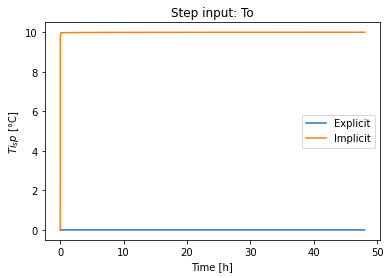

In [50]:
n_s = As.shape[0]                      # number of state variables
Œ∏_exp = np.zeros([n_s, t.shape[0]])    # explicit Euler in time t
Œ∏_imp = np.zeros([n_s, t.shape[0]])    # implicit Euler in time t

I = np.eye(n_s)                        # identity matrix

for k in range (n -1) :
    # Œ∏_exp[:, k + 1] = (I + dt * As).dot(Œ∏_exp[:, k]) + dt * Bs @ u[:, k]
    Œ∏_imp[:, k + 1] = np.linalg.inv(I - dt * As).dot((Œ∏_imp[:, k] + dt * Bs @ u[:, k]))
    
y_exp = Cs @ Œ∏_exp + Ds @  u
y_imp = Cs @ Œ∏_imp + Ds @  u

fig, ax = plt.subplots()
ax.plot(t / 3600, y_exp.T, t / 3600, y_imp.T)
ax.set(xlabel='Time [h]',
       ylabel='$Ti_sp$ [¬∞C]',
       title='Step input: To')
ax.legend(['Explicit', 'Implicit'])
plt.show()

In [51]:
print('Steady-state indoor temperature obtained with:')
print(f'- DAE model: {float(Œ∏[6]):.4f} ¬∞C')
print(f'- state-space model: {float(yss):.4f} ¬∞C')
print(f'- steady-state response to step input: {float(y_exp[:, -2]):.4f} ¬∞C')

Steady-state indoor temperature obtained with:
- DAE model: 21.1454 ¬∞C
- state-space model: 21.1454 ¬∞C
- steady-state response to step input: 0.0000 ¬∞C


Il y a un probl√®me dans le code car les valeurs ne sont pas du tout proche. 

**Conditions de simulation**

* Localisation : Nous √©tudions toujours le b√¢timent au m√™me endroit.

* Flux solaire : Le flux solaire est la somme des flux diffus, r√©fl√©chi et direct. Cette partie a d√©j√† √©t√© d√©taill√©e plus haut, nous reprendrons donc les r√©sultats pr√©c√©demment √©tablis (flux sur murs nord, est, sud, ouest)

* Resample weather data : D√©fnir pas delta t et associ√©e √† chaque it√©ration une valeur de weather_data

* Autres donn√©es : Ti_sp et Qa (flux auxiliaire) sont consid√©r√©s constants tout le long de la simulation

* Input vector : u √† red√©finir

* Condition initiale : A t = 0, on choisis de fixer Œ∏ √† 0.
  
Ainsi il vient, 

In [52]:
# FLux solaire
# Gtot = Gtot_NEO + Gtot_S
rad_surf['Gtot_S'] = rad_surf.sum(axis=1)

# Resample weather data
data = pd.concat([weather_data['temp_air'], rad_surf['Gtot_S']], axis=1)   # Red√©finition de data
data = data.resample(str(dt) + 'S').interpolate(method='linear')
data = data.rename(columns={'temp_air': 'To'})
pd.DataFrame(data)

# Autres donn√©es
data['Ti_sp'] = 15 * np.ones(data.shape[0])
data['Qa'] = 0 * np.ones(data.shape[0])
pd.DataFrame(data) # ou 100 comme au steady-state

# Input Vector
To = data['To']
Ti_sp = data['Ti_sp']
Œ¶o = Œ±_coulc * wall['Surface']['Beton'] * data['Gtot_S']
Œ¶i = œÑ_vc * Œ±_coulc * wall['Surface']['Verre'] * data['Gtot_S']
Qa = data['Qa']
Œ¶a = Œ±_vc * wall['Surface']['Verre'] * data['Gtot_S']

u = pd.concat([To, To, To, Ti_sp, Œ¶o, Œ¶i, Qa, Œ¶a], axis=1)
u.columns.values[[4, 5, 7]] = ['Œ¶o', 'Œ¶i', 'Œ¶a']
pd.DataFrame(u)

# Initial condition
Œ∏_exp = 0 * np.ones([As.shape[0], u.shape[0]])

**Int√©gration temporelle**

In [53]:
# Par la m√©thode explicite d'Euler
for k in range(u.shape[0] - 1):
    Œ∏_exp[:, k + 1] = (I + dt * As) @ Œ∏_exp[:, k]\
        + dt * Bs @ u.iloc[k, :]
    
# D√©termination de output vector et q_hvac
y_exp = Cs @ Œ∏_exp + Ds @ u.to_numpy().T
q_hvac = Kp * (data['Ti_sp'] - y_exp[0, :]) # Pour tout t dans duration
np.shape(y_exp)

(1, 41401)

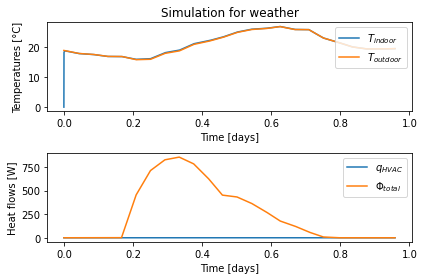

In [54]:
i = np.arange(data.shape[0])
t = dt * i  # time vector

fig, axs = plt.subplots(2, 1)
# plot indoor and outdoor temperature
axs[0].plot(t / 3600 / 24, y_exp[0, :], label='$T_{indoor}$')
axs[0].plot(t / 3600 / 24, data['To'], label='$T_{outdoor}$')
axs[0].set(xlabel='Time [days]',
           ylabel='Temperatures [¬∞C]',
           title='Simulation for weather')
axs[0].legend(loc='upper right')

# plot total solar radiation and HVAC heat flow
axs[1].plot(t / 3600 / 24,  q_hvac, label='$q_{HVAC}$')
axs[1].plot(t / 3600 / 24, data['Gtot_S'], label='$Œ¶_{total}$')
axs[1].set(xlabel='Time [days]',
           ylabel='Heat flows [W]')
axs[1].legend(loc='upper right')

fig.tight_layout()

In [55]:
# Surface du mur (b√©ton)
Œµ_bg = 0.85       # Emissivit√© : Grande longueur d'onde
Œ±_coulc = 0.25    # Absorptivit√© : Courte longueur d'onde : mur de couleur blanche

# Verre
Œµ_vg = 0.90       # Emissivit√© : Grande longueur d'onde
Œ±_vc = 0.38       # Absorptivit√© : Courte longueur d'onde
œÑ_vc = 0.30       # Transmittance : Courte longueur d'onde
t = dt * np.arange(data.shape[0])
t

array([    0,     2,     4, ..., 82796, 82798, 82800])

**Fin du code en dynamique**

## Optimisation du syst√®me : Equipement id√©al

### Valeurs vis√©es pour chacun des environnements

On cherche √† atteindre une certaine temp√©rature, dite temp√©rature de confort Ti_sp, en ne modifiant que les √©quipements superficiels de notre b√¢timent et sans consommation d'un climatiseur ou d'un chauffage. Afin de souligner les modifications superficielles du syst√®me, on ajoute 2 autres environnements : un de temp√©rature moyenne ti√®de, un plut√¥t chaude.

* Cas de la Russie : Ti_sp = 15 ¬∞C
* Cas de l'Argentine : Ti_sp = 22 ¬∞C
* Cas de l'Afrique du Sud : Ti_sp = 16 ¬∞C

### Param√®tres modifiables

Pour atteindre cette temp√©rature, il est possible de modifier :  
1) les mat√©riaux superficiels  
2) la couleur des murs en surface  
3) l'√©paisseur des 4 murs  

### Tableau des mat√©riaux

En se basant sur le tableau d'√©missivit√© stock√© dans le Stock doc :

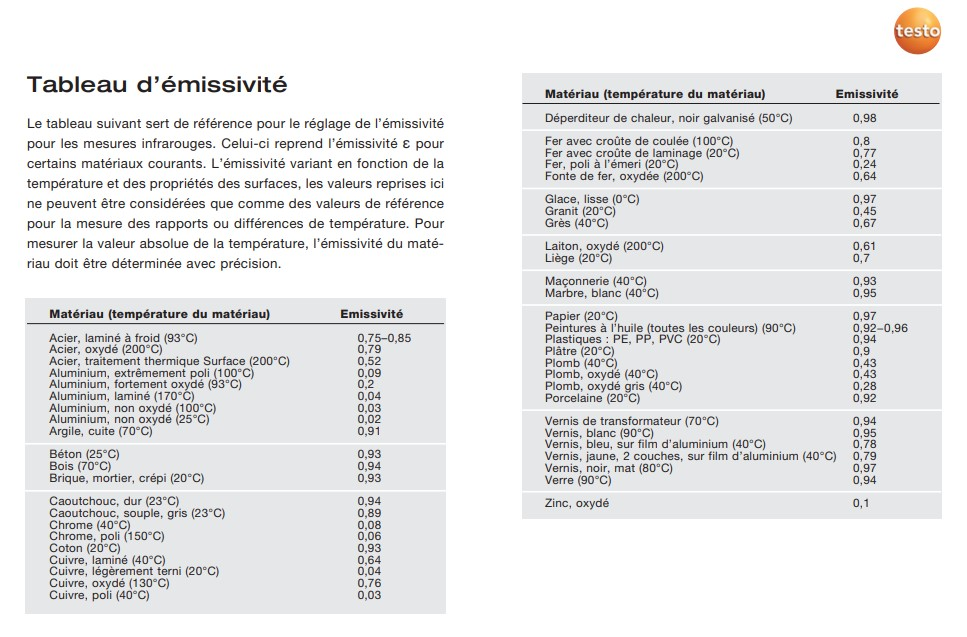
> Figure 7. Tableau d'√©missivit√©

On d√©finira nos propri√©t√©s pour les mat√©riaux que nous choisirons pour construire notre bati par la suite. 
On fera attention au condition de temp√©rature dans laquelle l'exp√©rience a √©t√© r√©alis√© pour trouver la valeur d'√©missivit√©. Ainsi, par prudence, car les temp√©ratures de r√©alisations sont tr√®s diff√©rentes de nos conditions environnementales, on prendra des valeurs plus faibles que celles inscrites (comparaison de valeurs avec le b√©ton car fix√©e √† 0.85 dans ce projet alors qu'il est √©gal √† 0.93 dans le tableau).

Voici la liste des mat√©riaux s√©lectionn√©s pour l'√©tude :

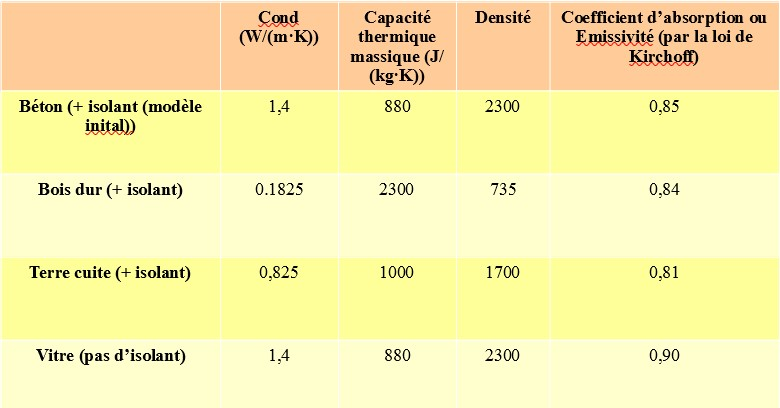
> Figure 8. Tableau des mat√©riaux s√©lectionn√©s dans le cadre du projet

### Processus de d√©termination des √©quipements id√©aux

La temp√©rature int√©rieure T6 est affin√©e selon nos modifications.

On commence par le choix des mat√©raux parmis ceux de la liste ci-dessus. 
Pour cela, il faut importer les fichiers weather_data de l'Argentine et de l'Afrique du Sud et modifier ensuite les param√®tres qui caract√©risent chaque mat√©riau soit la conductivit√©, la capacit√© thermique, la densit√© et enfin le coefficient d'√©missivit√©.
(code dans d√©finition des mat√©riaux utilis√©s)

Ce qui nous donne :
* Russie  
B√©ton + isolant : T6 = -1.687 ¬∞C
Bois + isolant : T6 = -1.687 ¬∞C
Terre cuite + isolant : T6 = -1.687 ¬∞C
Vitre + isolant : -1.68 ¬∞C

A premi√®re vue, on constate que les temp√©ratures sont vari√©es au centi√®me pr√®s, la modification des propri√©t√©s des mat√©riaux n'influencent pas la temp√©rature int√©rieure de la maison. Il est √† ce stade difficile de voir quel mat√©riau serait id√©al pour le confort de la maison dans son environnemet.

* Argentine # albedo = 0.2  
B√©ton + isolant : T6 = 24.982 ¬∞C
Bois + isolant : T6 = 24.981 ¬∞C
Terre cuite + isolant : T6 = 24.982 ¬∞C
Vitre + isolant : 25.015 ¬∞C

* Affrique du Sud # albdeo = 0.2
B√©ton + isolant : T6 = 21.145 ¬∞C
Bois + isolant : T6 = 21.144 ¬∞C
Terre cuite + isolant : T6 = 21.445 ¬∞C
Vitre + isolant : 21.192 ¬∞C

Sachant que les temp√©ratures de confort sont diff√©rentes pour chacun des cas (cf Valeurs vis√©es pour chacun des environnements), on va donc soit chercher √† r√©chauffer la maison soit √† le refroidir.
Ainsi, on s√©lectionne (en gras) pour la Russie le mat√©riau qui permet d'augmenter le plus possible la temp√©rature int√©rieure et pour les 2 autres pays, on r√©alise le processus inverse : 

* Russie  
B√©ton + isolant : T6 = -1.687 ¬∞C
Bois + isolant : T6 = -1.687 ¬∞C
Terre cuite + isolant : T6 = -1.687 ¬∞C
**Vitre + isolant : -1.68 ¬∞C**

* Argentine # albedo = 0.2  
B√©ton + isolant : T6 = 24.982 ¬∞C
**Bois + isolant : T6 = 24.981 ¬∞C**
Terre cuite + isolant : T6 = 24.982 ¬∞C
Vitre + isolant : 25.015 ¬∞C

* Affrique du Sud # albdeo = 0.2
B√©ton + isolant : T6 = 21.145 ¬∞C
**Bois + isolant : T6 = 21.144 ¬∞C**
Terre cuite + isolant : T6 = 21.445 ¬∞C
Vitre + isolant : 21.192 ¬∞C

Maintenant que nous avons d√©finis le mat√©riau, on va chercher √† modifier le bati gr√¢ce √† diff√©rentes solutions selon les besoins de chaque cas.
Pour l'Argentine et l'Afrique, il est encore possible de modifier l'√©paisseur en l'augmentant. Le mur √©tant d√©j√† de couleur blanche, il n'est pas possible de modifier la couleur sans qu'elle augmente la temp√©rature int√©rieure de la pi√®ce.
La Russie a des besoins totalement diff√©rentes. La temp√©rature est glaciale, l'objectif est de r√©chauffer la pi√®ce. Aisni, il est possible de diminuer l'√©paisseur des vitres et de tendre la couleur vers le noir pour une plus absorptivit√©.

En changeant l'√©paisseur : 
la Russie a gagn√© 0.009 ¬∞C, l'Argentine a perdu 0.002 ¬∞C et l'Afrique du Sud 0.003 ¬∞C.

De m√™me avec des modifications sur la couleur :
La Russie en gagne 0.047 de plus, ce qui est √©norme par rapport √† la variation de temp√©rature due √† la modification de l'√©paisseur.

On souligne qu'en terme d'efficacit√©, il est pr√©f√©rable de changer la couleur de la peinture plut√¥t que l'√©paisseur et m√™me le mat√©riau lui-m√™me.

### Conclusion 

L'objectif au d√©part √©tait de moins consommer le climatiseur et le chauffage en modifiant les √©quipements superficiels du b√¢timent afin de tendre la temp√©rature int√©rieure le plus possible vers la temp√©rature de confort.
D'apr√®s les diff√©rentes simulations, la modification la plus efficace est celle de la couleur plut√¥t que l'√©paisseur et le mat√©riau. 
De plus, pour chauffer une maison, il faut r√©duire les √©paisseurs des murs ce qui est limit√© car on atteint vite le 0, il faut donc miser sur d'autres param√®tres. Pour climatiser une pi√®ce, il faut au contraire augmenter les √©paisseurs mais sont tr√®s √©puisables en termes de ressource pour en r√©alit√© pas grand r√©sultat.
En effet, les variations de temp√©rature se font au centi√®me, ce qui est n√©gligeable √† notre √©chelle car c'est trop pr√©cis.

Ainsi, nous pouvons en conclure que modifier les mat√©riaux, les √©paisseurs et la couleur des murs influencent tr√®s peu la temp√©rature int√©rieure. La temp√©rature int√©rieure et ext√©rieure sont quasiment les m√™mes. Il faut trouver un compromis pour construire un bat√Æment faisable et qui se rapproche le plus possible de notre temp√©rature id√©ale √† l'int√©rieur de la maison.

## Am√©lioration possible

Le mod√®le actuel n'est pas une repr√©sentation exacte de la r√©alit√©. Pour plusieurs raisons qui sont √©num√©r√©s comme suit :
* Les flux solaires √©clairent uniquement les faces Sud et Est des murs. Alors qu'il y a √©galement toutes les autres faces. Il y a donc plus de r√©chauffement de la pi√®ce.
* Les flux radiatifs sont en r√©alit√© compt√©s entre les surfaces internes. Cela fausse donc √©galement les r√©sultats qui s'orientent vers une augmentation de la temp√©rature.
* La conversion du mod√®le en dynamique n'a pas pu √™tre r√©alis√©, cela aurait pu nous rapprocher plus du mod√®le de la r√©alit√©.
* Les √©changes radiatifs √† l'int√©rieur du cube auraient pu modifier des r√©sultats notamment dans la partie modification des couleurs qui a fait bouger un peu le mod√®le.